# Global Mart Sales Forecasting

In [189]:
# Importing the libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# For Decomposition
from pylab import rcParams
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

In [190]:
# For display

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [191]:
# Reading the dataset

df_gb = pd.read_csv("Global+Superstore+Data.csv")
df_gb.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [192]:
df_gb.memory_usage()

Index            128
Order Date    410320
Segment       410320
Market        410320
Sales         410320
Profit        410320
dtype: int64

In [193]:
df_gb.shape

(51290, 5)

## Data Understanding

In [194]:
df_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [195]:
df_gb.describe()

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
max,22638.480000,8399.976000


### Handling the datetime column

In [196]:
df_gb['Order Date'] = pd.to_datetime(df_gb['Order Date'],format="%d-%m-%Y")

In [197]:
# Introducing the month feature to aggregte the values month-wise later

df_gb['Month'] = df_gb['Order Date'].dt.strftime('%Y-%m')

In [198]:
df_gb['Month'] = pd.to_datetime(df_gb['Month'],format="%Y-%m")

In [199]:
# Re-setting the index

df_gb = df_gb.set_index('Order Date')

In [200]:
df_gb.head()

,Segment,Market,Sales,Profit,Month
Order Date,,,,,
2012-07-31,Consumer,US,2309.650,762.1845,2012-07-01
2013-02-05,Corporate,APAC,3709.395,-288.7650,2013-02-01
2013-10-17,Consumer,APAC,5175.171,919.9710,2013-10-01
2013-01-28,Home Office,EU,2892.510,-96.5400,2013-01-01
2013-11-05,Consumer,Africa,2832.960,311.5200,2013-11-01


In [201]:
df_gb.tail()

,Segment,Market,Sales,Profit,Month
Order Date,,,,,
2014-06-19,Corporate,APAC,65.100,4.5000,2014-06-01
2014-06-20,Consumer,US,0.444,-1.1100,2014-06-01
2013-12-02,Home Office,US,22.920,11.2308,2013-12-01
2012-02-18,Home Office,LATAM,13.440,2.4000,2012-02-01
2012-05-22,Consumer,LATAM,61.380,1.8000,2012-05-01


## Data Preparation

### Preparing Data to Calculate Coefficient of Variation (CoV)

`The coefficient of variation is a ratio of the standard deviation to mean`. When we carefully observe the dataset, we can see that among the available market segments, the mean of the profits for these market segments varies quite a bit. Also, the standard deviation for the profits varies in a similar manner and it is meaningless to compare standard deviations across all the market segments. As a better metric to compare the variance between the segments, we will use the coefficient of variation. `It normalises the standard deviation and gives us a comparative figure on the basis of which we can identify the most profitable market segment`.

The data first of all will be prepared in order to calculate CoV.

In [202]:
# Deriving the Market-Segment feature

df_gb['Market-Segment'] = df_gb['Market'] + ' ' + df_gb['Segment']
df_gb.head()

,Segment,Market,Sales,Profit,Month,Market-Segment
Order Date,,,,,,
2012-07-31,Consumer,US,2309.650,762.1845,2012-07-01,US Consumer
2013-02-05,Corporate,APAC,3709.395,-288.7650,2013-02-01,APAC Corporate
2013-10-17,Consumer,APAC,5175.171,919.9710,2013-10-01,APAC Consumer
2013-01-28,Home Office,EU,2892.510,-96.5400,2013-01-01,EU Home Office
2013-11-05,Consumer,Africa,2832.960,311.5200,2013-11-01,Africa Consumer


In [203]:
# Grouping by Market-Segment to calculate total profit for each market segment

df_grouped = df_gb.groupby('Market-Segment')['Profit'].sum()
df_grouped = pd.DataFrame(df_grouped)
df_grouped

,Profit
Market-Segment,
APAC Consumer,222817.56040
APAC Corporate,129737.23480
APAC Home Office,83445.25380
Africa Consumer,47772.09900
Africa Corporate,20686.96500
Africa Home Office,20412.56700
Canada Consumer,9677.70000
Canada Corporate,5036.46000
Canada Home Office,3103.23000


### Looks like APAC Consumer is the most profitable of all market segments

In [204]:
# Lets see it the other way

pivot = pd.pivot_table(df_gb,index = 'Month', columns = 'Market-Segment', values = 'Profit', aggfunc = 'sum')
pivot

Market-Segment,APAC Consumer,APAC Corporate,APAC Home Office,Africa Consumer,Africa Corporate,Africa Home Office,Canada Consumer,Canada Corporate,Canada Home Office,EMEA Consumer,EMEA Corporate,EMEA Home Office,EU Consumer,EU Corporate,EU Home Office,LATAM Consumer,LATAM Corporate,LATAM Home Office,US Consumer,US Corporate,US Home Office
Month,,,,,,,,,,,,,,,,,,,,,
2011-01-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.70,NaN,-2099.364,1555.512,116.400,-845.8290,501.9315,975.3600,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02-01,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,982.092,216.690,-1808.1180,2988.4065,-181.0410,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03-01,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,390.102,78.972,2480.5410,736.9890,503.2230,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04-01,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,93.900,-420.090,2496.6405,1056.1785,63.8580,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05-01,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,-24.270,262.968,254.0805,1586.2740,201.1020,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088
2011-06-01,4328.2596,1435.8294,3452.1018,-1290.639,-259.218,-774.801,7.50,40.08,23.40,-267.030,2075.010,-2371.776,4317.4515,2270.8170,1210.2930,1039.27972,2558.46696,643.69764,3486.7664,67.0149,1422.7431
2011-07-01,1258.9617,525.4647,-42.0498,621.168,134.847,-506.562,47.28,528.33,8.40,-942.603,273.756,-150.114,760.6920,916.9500,418.9350,1906.45620,303.29032,363.28400,-2227.2786,1308.7058,77.0902
2011-08-01,775.8066,4070.5581,775.7616,232.917,915.885,1090.200,43.68,29.70,NaN,285.270,-106.146,183.276,5498.6715,1626.2670,184.6140,1946.89372,180.54028,661.66792,2157.7522,2245.4838,914.8690
2011-09-01,5181.4449,1952.4675,623.3595,-86.163,950.766,1345.740,134.01,10.17,NaN,1012.101,-830.574,1151.358,5921.8785,5390.6625,2492.9010,1632.48620,386.77900,179.39744,8312.1203,-948.1010,964.0801


We have 48 months of data in total. Now, lets take the last 6 months as test data ands the rest as train data. Then lets calculate the CoV to find out the most profitable Market Segment.

In [205]:
train_pivot = pivot[:42]
test_pivot = pivot[42:]

#### Finding the most profitable Market Segment using Coeffecient of Variation

In [206]:
CoV = train_pivot.std(axis = 0)/train_pivot.mean(axis = 0)
CoV = pd.DataFrame(CoV, columns = ['CoV'])
CoV = CoV.sort_values(by = 'CoV')
CoV

,CoV
Market-Segment,
APAC Consumer,0.603633
EU Consumer,0.655334
LATAM Consumer,0.688935
EU Corporate,0.697702
APAC Corporate,0.740799
LATAM Corporate,0.890930
US Corporate,1.039660
APAC Home Office,1.061530
US Consumer,1.108571


Seems like APAC Consumer is the clear winner as it has the least CoV of all the Market Segments. Now, from this point onwards, I would forecast the sales for this Market-Segment.

In [207]:
# Filtering for APAC Consumer

df_gb = df_gb.loc[df_gb['Market-Segment'] == 'APAC Consumer']
df_gb.head()

,Segment,Market,Sales,Profit,Month,Market-Segment
Order Date,,,,,,
2013-10-17,Consumer,APAC,5175.171,919.971,2013-10-01,APAC Consumer
2011-11-07,Consumer,APAC,1822.080,564.840,2011-11-01,APAC Consumer
2012-04-14,Consumer,APAC,5244.840,996.480,2012-04-01,APAC Consumer
2013-06-06,Consumer,APAC,3701.520,1036.080,2013-06-01,APAC Consumer
2012-02-25,Consumer,APAC,1878.720,582.360,2012-02-01,APAC Consumer


In [208]:
df_gb = df_gb.groupby('Month')['Sales'].sum()
df_gb = pd.DataFrame(df_gb)
df_gb

,Sales
Month,
2011-01-01,15711.7125
2011-02-01,12910.8588
2011-03-01,19472.5632
2011-04-01,15440.3046
2011-05-01,24348.9723
2011-06-01,27260.0196
2011-07-01,15842.8317
2011-08-01,22012.2366
2011-09-01,34613.1849


## Timer-Series Analysis

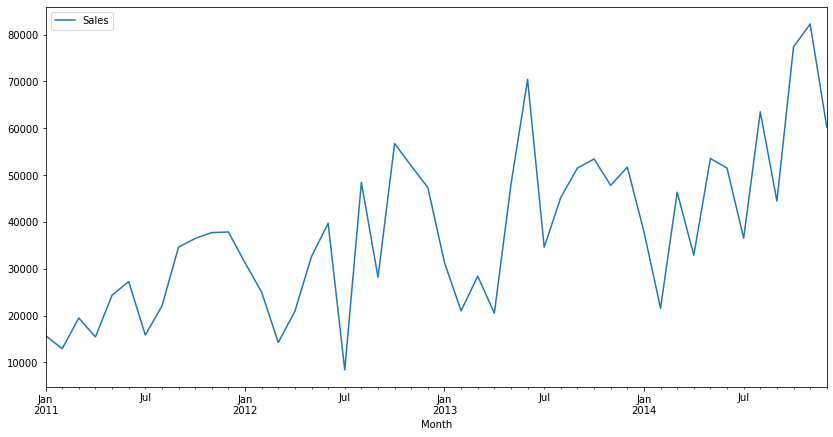

In [209]:
# Lets try plotting the series first to see the possible patterns like trend and seasonality

df_gb.plot(figsize = [14,7])
plt.legend(loc = 'best')
plt.show()

Seems like it has an upward trend and some seasonal components as well. Also, as seen from the above plot, there are no missing values.

### Outlier Detection

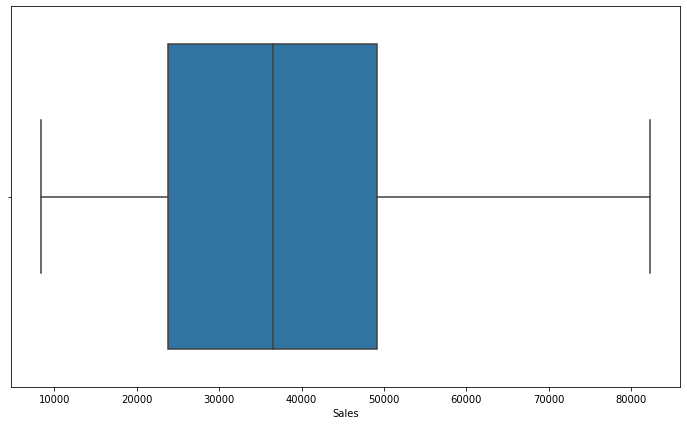

In [210]:
sns.boxplot(x = 'Sales', data = df_gb)
plt.show()

No such outliers. Good to go.

### Lets try to decompose the time series to extract the trend and seasonality and make some conclusions.

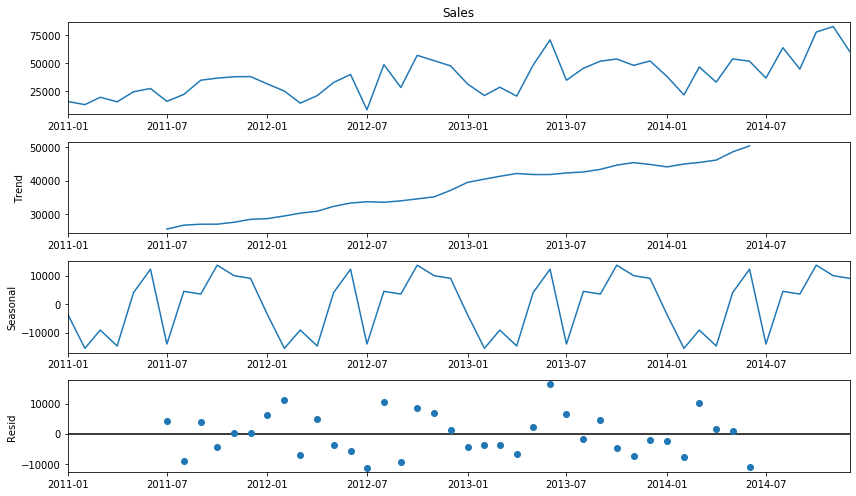

In [211]:
# Additive Decomposition

rcParams['figure.figsize'] = 12,7
decomposition = sm.tsa.seasonal_decompose(df_gb['Sales'],model='additive')
decomposition.plot()
plt.show()

Lets also try multiplicative decomposition as the residuals show some pattern

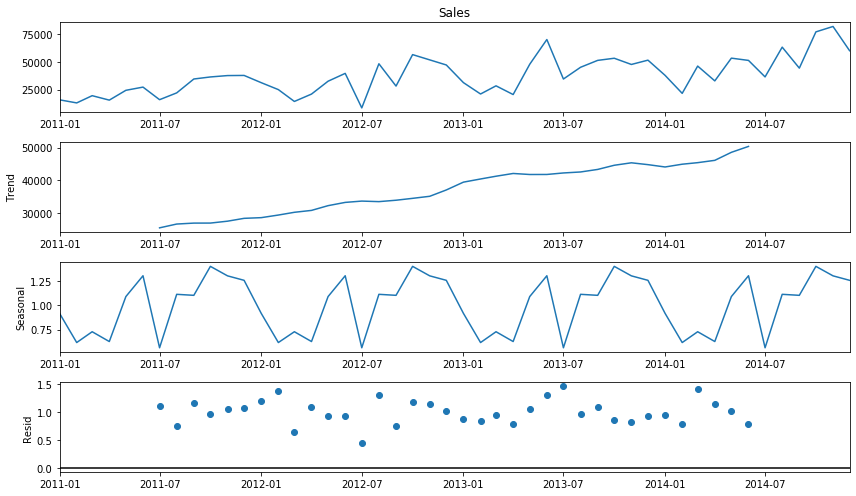

In [212]:
# Multiplicative Decomposition

rcParams['figure.figsize'] = 12,7
decomposition = sm.tsa.seasonal_decompose(df_gb['Sales'],model='multiplicative')
decomposition.plot()
plt.show()

The consistently incresing trend is quite evident. Also, the seasonality extract shows the dip in Sales every year in the month of July. The middle months show higher sales in general.

## Model Building

In [213]:
# Splitting the data

train = df_gb[:42]
test = df_gb[42:]

**Now, I will be using different families of Machine Learning models for Time Series Forecasting namely, Simple Methods, Smoothing models and Auto-Regressive models. The 6 month of test data would be used to calculate the error in forecasting.**

## Simple Methods

### Naive Method

In [214]:
df_naive = test.copy()
df_naive['Sales'] = train['Sales'][41]

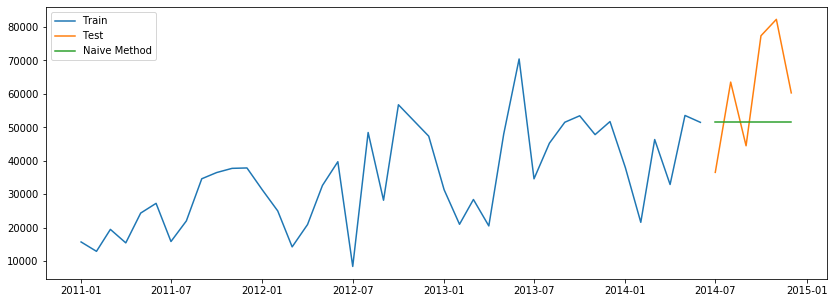

In [215]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_naive['Sales'],label="Naive Method")
plt.legend(loc='best')
plt.show()

In [216]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_naive['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_naive['Sales'])/test['Sales']),2)

error_results = pd.DataFrame({'Method':'Naive Method','RMSE':[rmse],'MAPE':[mape]})
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86


### Simple Average Method

In [217]:
df_sa = test.copy()
df_sa['Sales'] = train['Sales'].mean()

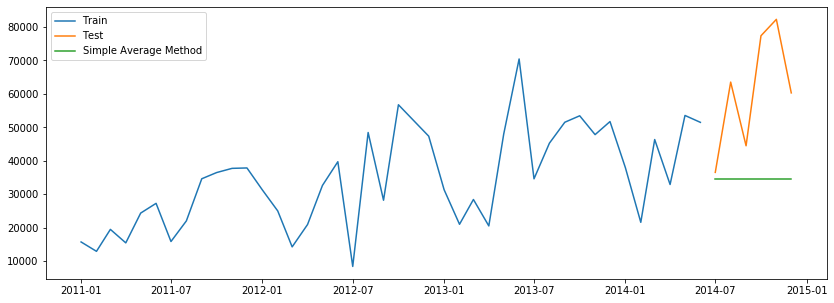

In [218]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_sa['Sales'],label="Simple Average Method")
plt.legend(loc='best')
plt.show()

In [219]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_sa['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_sa['Sales'])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Simple Average Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18


### Moving Average Method

In [220]:
# Lets take the rolling window to be 3 months

df_ma = df_gb.copy()
df_ma['Sales'] = train['Sales'].rolling(3).mean()
df_ma['Sales'][42:] = df_ma['Sales'][41]

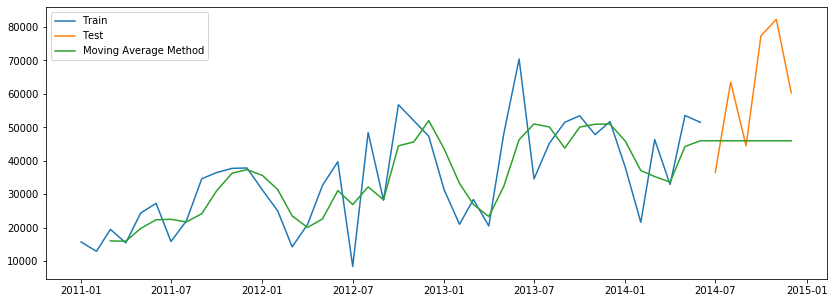

In [221]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_ma['Sales'],label="Moving Average Method")
plt.legend(loc='best')
plt.show()

In [222]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_ma['Sales'][42:])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_ma['Sales'][42:])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Moving Average Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55


## Exponential Smoothing Methods

### Simple Exponential

In [223]:
# Importing the relevant library 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [224]:
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized = True)

df_SE = test.copy()
df_SE['Sales'] = model_fit.forecast(6)

In [225]:
model_fit.params

{'smoothing_level': 0.21419003177889367,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 19962.57893809655,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

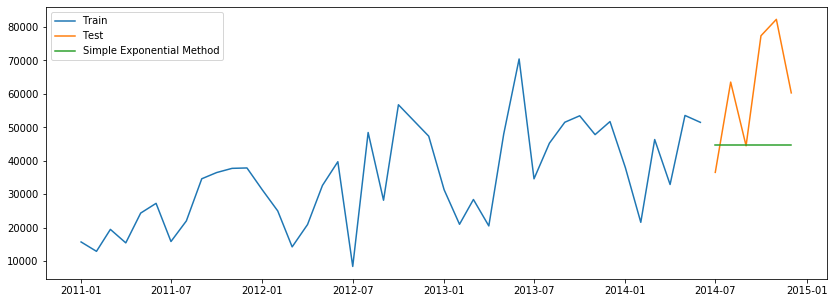

In [226]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_SE['Sales'],label="Simple Exponential Method")
plt.legend(loc='best')
plt.show()

Simple Exponential Method only takes care of the level component as it can be seen from the above plot.

In [227]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_SE['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_SE['Sales'])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Simple Exponential Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73


### Holt's Exponential

In [228]:
# Importing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [229]:
df_HE = test.copy()

model = ExponentialSmoothing(train['Sales'],trend='additive',seasonal_periods = 12, seasonal = None)
fit = model.fit(optimized=True)
df_HE['Sales'] = fit.forecast(6)
fit.params

{'smoothing_level': 4.747717636928819e-11,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 17037.860060149687,
 'initial_slope': 772.9027165016946,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

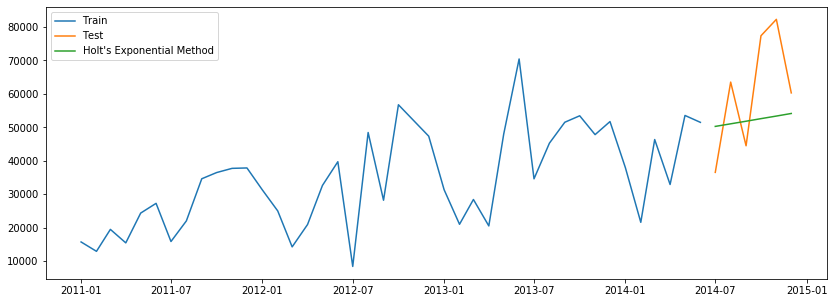

In [230]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_HE['Sales'],label="Holt's Exponential Method")
plt.legend(loc='best')
plt.show()

Holt's Exponential captures trend as well.

In [231]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_HE['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_HE['Sales'])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Holts Exponential Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20


### Holt Winter's Additive Smoothing Method

In [232]:
df_HWA = test.copy()

model = ExponentialSmoothing(np.asarray(train['Sales']),trend='additive',seasonal_periods = 12, seasonal = 'additive')
fit = model.fit(optimized=True)
df_HWA['Sales'] = fit.forecast(6)
fit.params

{'smoothing_level': 0.052631578947367676,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.10526315789474944,
 'damping_slope': nan,
 'initial_level': 29061.291899999593,
 'initial_slope': 730.4167145833245,
 'initial_seasons': array([-13349.5794, -16150.4331,  -9588.7287, -13620.9873,  -4712.3196,
         -1801.2723, -13218.4602,  -7049.0553,   5551.893 ,   7410.7551,
          8661.312 ,   8785.6992]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

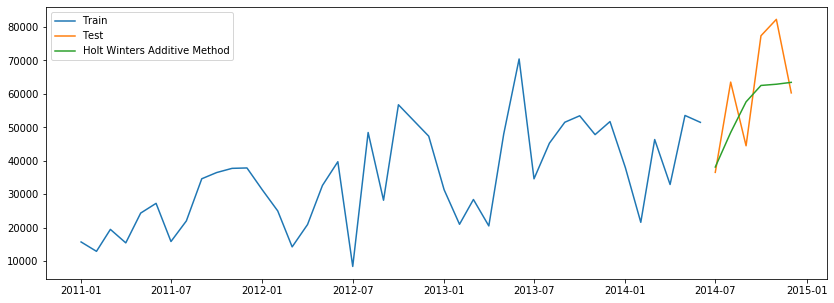

In [233]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_HWA['Sales'],label="Holt Winters Additive Method")
plt.legend(loc='best')
plt.show()

In [234]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_HWA['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_HWA['Sales'])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Holt Winters Additive Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61


### Holt Winter's Multiplicative Smoothing Method

In [235]:
df_HWM = test.copy()

model = ExponentialSmoothing(np.asarray(train['Sales']),trend='additive',seasonal_periods = 12, seasonal = 'multiplicative')
fit = model.fit(optimized=True)
df_HWM['Sales'] = fit.forecast(6)
fit.params

{'smoothing_level': 0.05263157894736842,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.21052631578947367,
 'damping_slope': nan,
 'initial_level': 29061.291900000004,
 'initial_slope': 730.4167145833347,
 'initial_seasons': array([0.54064054, 0.44426307, 0.67005153, 0.53130138, 0.83784893,
        0.93801816, 0.54515235, 0.75744178, 1.19104082, 1.25500432,
        1.29803603, 1.3023162 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

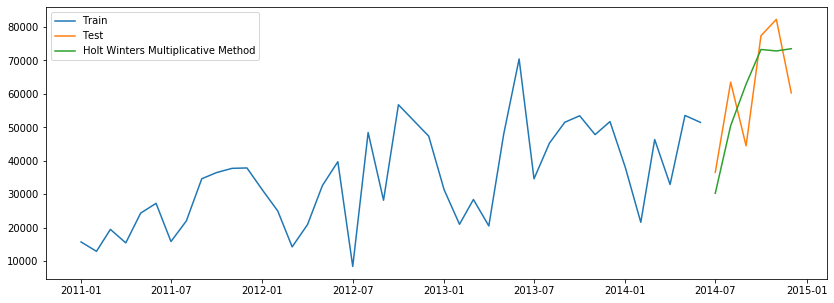

In [236]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_HWM['Sales'],label="Holt Winters Multiplicative Method")
plt.legend(loc='best')
plt.show()

In [237]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_HWM['Sales'])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_HWM['Sales'])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Holt Winters Multiplicative Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62


Clearly, since the time-series data has seasonality as we saw during the decomposition, Holt Winters Methods perform the best as they capture the seasonal component, giving the least errors. We can prefer the `Holt Winters' Additive method` amongst all the smoothing techniques applied on the data. But lets further proceed to applying some autoregressive techniques as well.

## Auto Regressive Methods

There are 2 assumptions that are taken before applying Auto Regressive methods. 
- Stationarity: The time series need to be stationary. It should have a constant mean and variance thorughout, along with a consistent covariance at a fixed lag. It should not show any trend or seasonality patterns.
- Auto-correlation: The variables are dependent and are influenced by their own lagged values.

Two formal tests for stationarity based on Hypothesis testing are `ADF` and `KPSS` tests.

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: Null Hypothesis - Stationary

In [238]:
# Import kpss package from statsmodels library

from statsmodels.tsa.stattools import kpss

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

kpss_test = kpss(df_gb['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.595515
Critical Values @ 0.05: 0.46
p-value: 0.023044


#### Augmented Dickey-Fuller (ADF) test: Null Hypothesis - Not Stationary

In [239]:
# Import adfuller package from statsmodels library

from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller (ADF) Test

adf_test = adfuller(df_gb['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.220857
Critical Values @ 0.05: -2.93
p-value: 0.198763


As we saw through above two tests, the time series is not stationary. Now, we need to make it stationary. We will use Box-cox transformation to make the variance constant and use first order differencing to make the mean constant. 

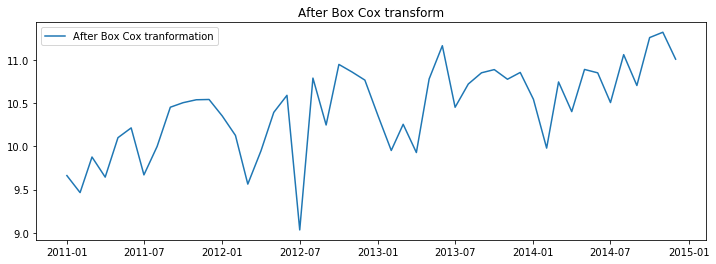

In [240]:
# Import boxcox package from scipy library

from scipy.stats import boxcox

# Boxcox transformation to make variance constant

df_boxcox = pd.Series(boxcox(df_gb['Sales'], lmbda=0), index = df_gb.index)

plt.figure(figsize=(12,4))
plt.plot(df_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

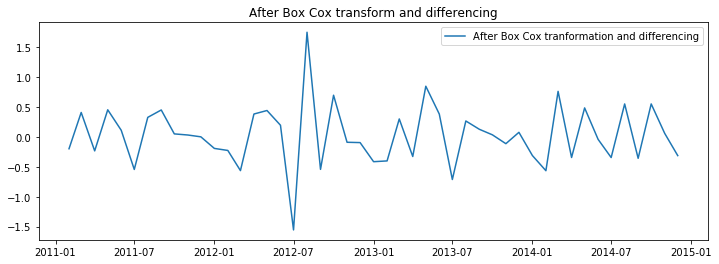

In [241]:
# Differencing

df_boxcox_diff = pd.Series(df_boxcox - df_boxcox.shift(),index = df_gb.index)

plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

Looks much more stationary than before. Good to proceed with the 2nd assumption now.

In [242]:
# Dropping the null values

df_boxcox_diff.dropna(inplace = True)

Lets confirm with ADH test.

In [243]:
# ADF Test on 'data_boxcox_diff'

adf_test = adfuller(df_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.769275
Critical Values @ 0.05: -2.95
p-value: 0.000001


Voila!!

#### Auto-Correlation function (ACF)

This function tells us about the correlation between an observation with its lagged values. It helps in determining which lag of the observation is influencing the most. Also, ACF captures both direct and indirect relationships between the observations.

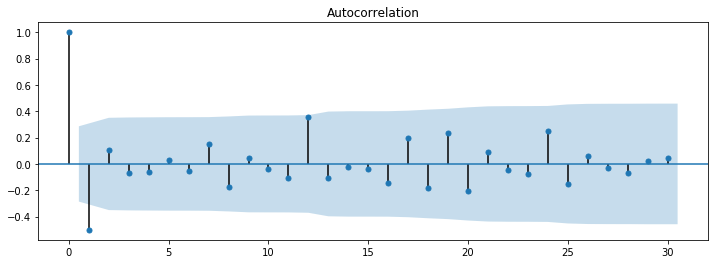

In [244]:
# Import plot_acf function from statsmodels library

from statsmodels.graphics.tsaplots import plot_acf

# Plot the Autocorrelation function (ACF) 

plt.figure(figsize=(12,4))
plot_acf(df_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

#### Partial Auto-Correaltion Function (PACF)

PACF captures only the direct relationships between the variables and the lagged values.

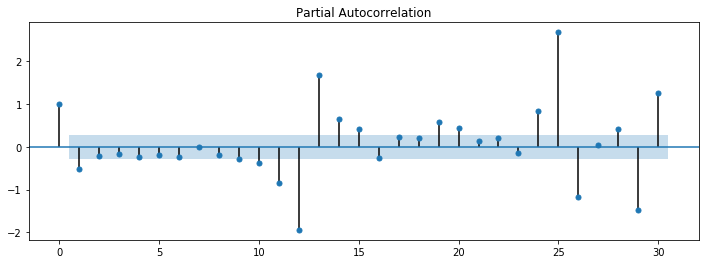

In [245]:
# Import plot_pacf function from statsmodels library

from statsmodels.graphics.tsaplots import plot_pacf

# Plot the Partial Autocorrelation function (PACF)

plt.figure(figsize=(12,4))
plot_pacf(df_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [246]:
# Train and Test splits for AR Models

train_df_boxcox = df_boxcox[:42]
test_df_boxcox = df_boxcox[42:]
train_df_boxcox_diff = df_boxcox_diff[:41]
test_df_boxcox_diff = df_boxcox_diff[41:]

Both the assumptions have been satisfied, lets proceed with model building.

### Simple AR Model

In [247]:
# Import ARIMA function from statsmodels library

from statsmodels.tsa.arima_model import ARIMA

# Set order for the AR model

model = ARIMA(train_df_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
model_fit.params

const      0.031320
ar.L1.y   -0.483978
dtype: float64

Now, the original time series need to be recovered as well.

In [248]:
# Recovering

df_SAR = df_boxcox_diff.copy()
df_SAR['boxdiff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
df_SAR['box'] = df_SAR['boxdiff'].cumsum()
df_SAR['box'] = df_SAR['box'].add(df_boxcox[0])
df_SAR['Sales'] = np.exp(df_SAR['box'])

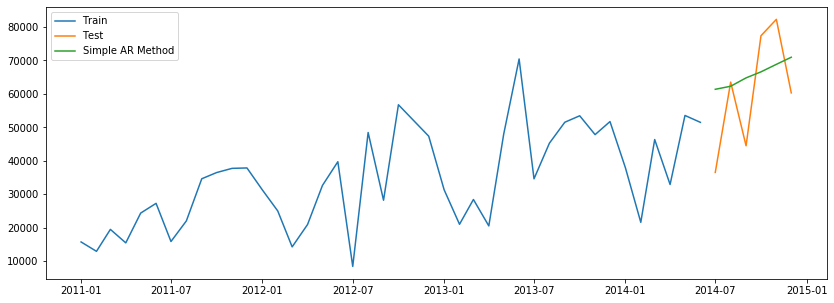

In [249]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_SAR['Sales'][test.index.min():],label="Simple AR Method")
plt.legend(loc='best')
plt.show()

In [250]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_SAR['Sales'][test.index.min():])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_SAR['Sales'][test.index.min():])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Simple AR Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62
0,Simple AR Method,15505.02,27.27


### Moving Average Method (MA)

In [251]:
model = ARIMA(train_df_boxcox_diff, order=(0, 0, 1)) 
model_fitmodel = ARIMA(train_df_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
model_fit.params = model.fit()
model_fit.params

const      0.022694
ma.L1.y   -1.000000
dtype: float64

In [252]:
# Recovering

df_MAR = df_boxcox_diff.copy()
df_MAR['boxdiff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
df_MAR['box'] = df_MAR['boxdiff'].cumsum()
df_MAR['box'] = df_MAR['box'].add(df_boxcox[0])
df_MAR['Sales'] = np.exp(df_MAR['box'])

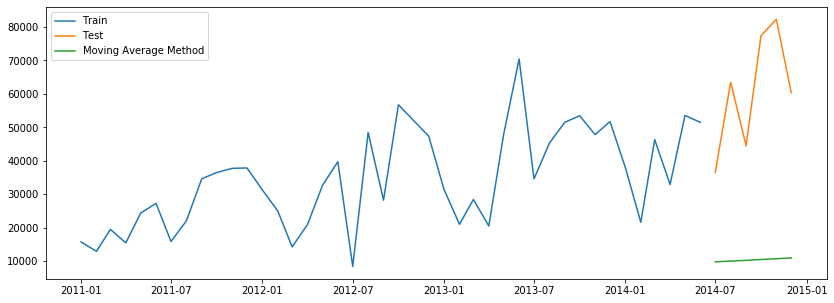

In [259]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_MAR['Sales'][test.index.min():],label="Moving Average Method")
plt.legend(loc='best')
plt.show()

In [254]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_MAR['Sales'][test.index.min():])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_MAR['Sales'][test.index.min():])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'Moving AR Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62
0,Simple AR Method,15505.02,27.27
0,Moving AR Method,52903.35,81.64


### Auto Regressive Moving Average Method (ARMA)

In [255]:
model = ARIMA(train_df_boxcox_diff, order=(1, 0, 1)) 
model_fit = model.fit()
model_fit.params

const      0.022810
ar.L1.y    0.115922
ma.L1.y   -0.999969
dtype: float64

In [256]:
# Recovering

df_ARMA = df_boxcox_diff.copy()
df_ARMA['boxdiff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
df_ARMA['box'] = df_ARMA['boxdiff'].cumsum()
df_ARMA['box'] = df_ARMA['box'].add(df_boxcox[0])
df_ARMA['Sales'] = np.exp(df_ARMA['box'])

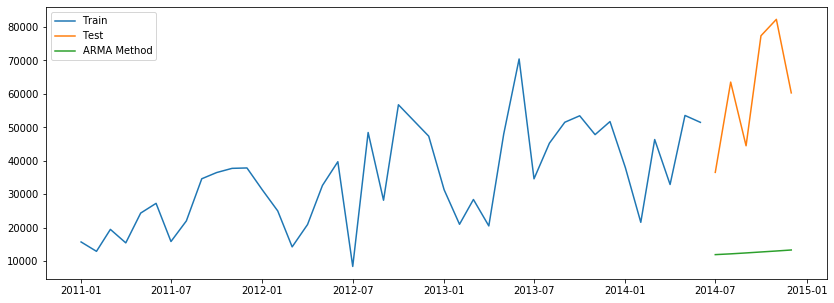

In [260]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_ARMA['Sales'][test.index.min():],label="ARMA Method")
plt.legend(loc='best')
plt.show()

In [258]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_ARMA['Sales'][test.index.min():])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_ARMA['Sales'][test.index.min():])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'ARMA Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62
0,Simple AR Method,15505.02,27.27
0,Moving AR Method,52903.35,81.64
0,ARMA Method,50757.93,77.66


### Auto Regressive Integrated Moving Average method (ARIMA)

In [261]:
model = ARIMA(train_df_boxcox, order=(1, 1, 1)) 
model_fit = model.fit()
model_fit.params

const        0.022810
ar.L1.D.y    0.115922
ma.L1.D.y   -0.999969
dtype: float64

In [262]:
# Recovering

df_ARIMA = df_boxcox_diff.copy()
df_ARIMA['boxdiff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
df_ARIMA['box'] = df_ARIMA['boxdiff'].cumsum()
df_ARIMA['box'] = df_ARIMA['box'].add(df_boxcox[0])
df_ARIMA['Sales'] = np.exp(df_ARIMA['box'])

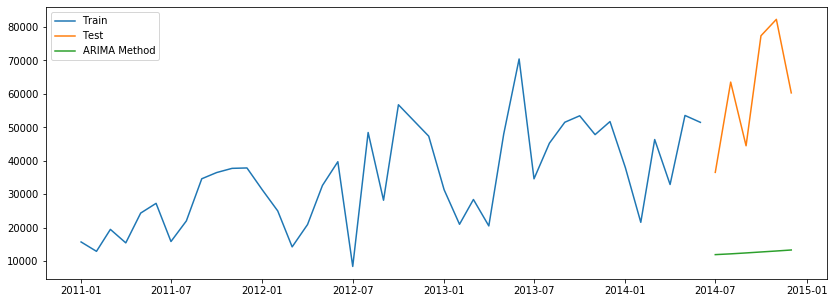

In [263]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_ARIMA['Sales'][test.index.min():],label="ARIMA Method")
plt.legend(loc='best')
plt.show()

In [264]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_ARIMA['Sales'][test.index.min():])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_ARIMA['Sales'][test.index.min():])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'ARIMA Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62
0,Simple AR Method,15505.02,27.27
0,Moving AR Method,52903.35,81.64
0,ARMA Method,50757.93,77.66


### Seasonal Auto Regressive Integrated Moving Average method (SARIMA)

In [265]:
# Import SARIMAX package from statsmodels library

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set order for the SARIMA model

model = SARIMAX(train_df_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)) 
model_fit = model.fit()
model_fit.params

ar.L1      -0.060969
ma.L1      -0.995440
ar.S.L12   -0.709637
sigma2      0.084622
dtype: float64

In [266]:
# Recovering

df_SARIMA = df_boxcox_diff.copy()
df_SARIMA['box'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
df_SARIMA['Sales'] = np.exp(df_SARIMA['box'])

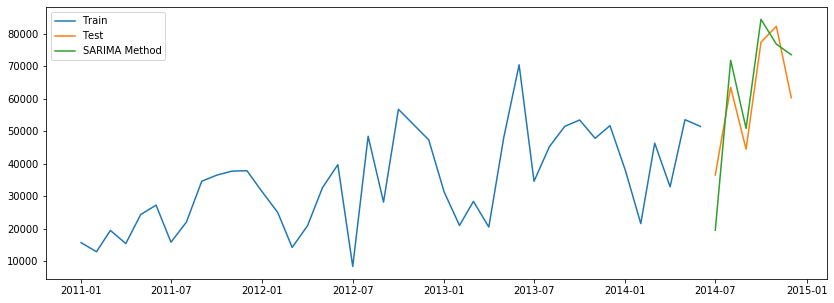

In [267]:
# Plotting

fig = plt.figure(figsize=[14,5])
plt.plot(train['Sales'],label="Train")
plt.plot(test['Sales'],label="Test")
plt.plot(df_SARIMA['Sales'][test.index.min():],label="SARIMA Method")
plt.legend(loc='best')
plt.show()

In [268]:
# Calculating the Root Mean Squared Error and Mean Absolute Percentage Error

rmse = np.sqrt(mean_squared_error(test['Sales'],df_SARIMA['Sales'][test.index.min():])).round(2)
mape = round(100*np.mean(np.abs(test['Sales'] - df_SARIMA['Sales'][test.index.min():])/test['Sales']),2)

error_results_temp = pd.DataFrame({'Method':'SARIMA Method','RMSE':[rmse],'MAPE':[mape]})
error_results = pd.concat([error_results,error_results_temp])
error_results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86
0,Simple Average Method,30846.00,38.18
0,Moving Average Method,22019.48,27.55
0,Simple Exponential Method,22991.87,27.73
0,Holts Exponential Method,17736.04,25.20
0,Holt Winters Additive Method,12971.01,17.61
0,Holt Winters Multiplicative Method,11753.42,19.62
0,Simple AR Method,15505.02,27.27
0,Moving AR Method,52903.35,81.64
0,ARMA Method,50757.93,77.66


Amongst the autoregressive models, SARIMA method gave us the best plot and least MAPE value, since there was seasonality in the data to deal with. We can therefore prefer `SARIMA` amongst all the autoregressive methods.

**After applying each of the above techniques and forecasting the `Sales` for the next 6 months, we can conclude that `Holt Winter's Additive Method` amongst the smoothing techniques and `SARIMA Method` amongst the autoregressive methods were able to best predict the sales closest to the actual values, also their MAPE values is the least amongst the lot. This gives us conclusive evidence supporting the fact that these 2 methods provide the best models in this case.**